In [1]:
import tensorflow as tf
import torch 
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from d2l import torch as d2l


# 3.5
- torchvision 패키지에서 여러 설정들을 통해서 이미지 데이터들을 transform 시킴으로서 불러들일 수 있다. (여기서는 Tensor변환만 시켰으나 추가적인 변환 넣음)

- 즉, Augmentation 진행

In [2]:
trans = transforms.Compose([
    transforms.RandomResizedCrop(size = 28, scale = (0.5, 1.0)), # 중간 기준 일부분만 잘라냄. (여기서는 그냥 정의만 함. )
    transforms.RandomHorizontalFlip(), # 옆으로 뒤집기
    transforms.RandomVerticalFlip(), # 위아래 뒤집기
    transforms.RandomRotation(10), # -10 ~ +10 도 기울기
    transforms.ToTensor() # 텐서로 변환 (이미지는 array, 텐서로 변환)
])



mnist_train = datasets.FashionMNIST(root = '../data', train = True, transform = trans,
                                   download = True)

mnist_test = datasets.FashionMNIST(root = '../data', train = False, transform = trans,
                                   download = True)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
def get_fashion_mnist_labels(labels): # 정수 인코딩으로 되어있는 것을 실제 나타내는 것으로 바꾸는 함수
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
# 환경에 따라서 이 함수가 작동 안할 수 있음... 내 환경에서는 작동 안함 ->> 보여지는 것일 뿐이므로, matplolib 사용.
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        
        # numpy 배열이면 바로 보여주고 아니면 배열화 시킨 후에 보여줌.
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.show(img)
            
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
            
    return axes

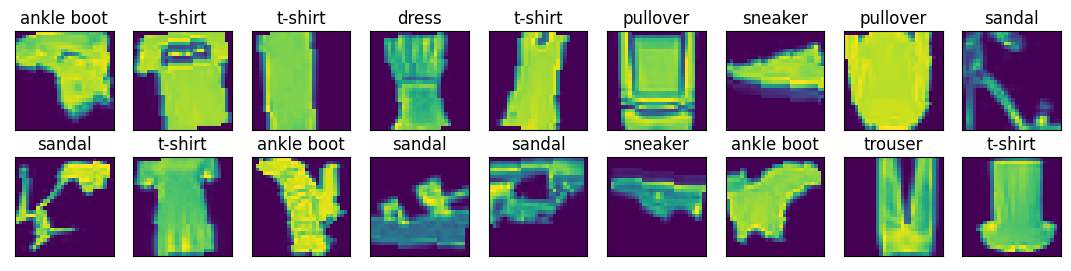

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
# d2l 패키지는 matplolib 과 연결된 것 같다. jupyter notebook에서 안나올 시 이것 실행.

# Dataloader 함수는 해당 데이터를 batch_size 크기만큼 잘라서 나오게 해준다. (X, y 데이터 같이.)
# 원래 사용법은 데이터 얻기 -> Subset 사용해서 Train / Test 데이터 분류 -> Dataloader 사용 이런식으로 흘러간다.
# CustomDataset 을 활용한다면 그냥 X,y 데이터 
X,y = next(iter(data.DataLoader(mnist_train, batch_size = 18))) # iteration 사용 -> 하나만 뽑아냄.

# 안나올 수도 있으니 위의 line magic 사용. (jupyter notebook에서 안나올 시 실행하는 함수.)
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [8]:
get_fashion_mnist_labels(y)[1]

't-shirt'

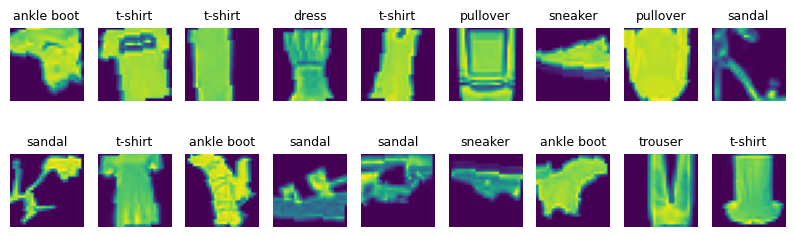

In [9]:

# 위 이미지 안나올 경우. matplolib을 사용해서 진행하였다.
plt.figure(figsize = (10,3))

for index in range(18):
    plt.subplot(2,9 ,index+1)
    plt.axis('off')
    plt.imshow(X[index,:,:,:].detach().numpy().reshape(28,28))
    plt.title( get_fashion_mnist_labels(y)[index],fontdict  = {'fontsize' : 9})

In [10]:
batch_size = 256

def get_dataloader_workers():
    return 4 # 컴퓨터 자원 중 processer 4개를 할당 (Tensor연산은 2의 제곱이 좋음)

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, # Dataloader 객체는 X,y 를 같이 넣어둠. 
                            num_workers = get_dataloader_workers())

In [11]:
timer = d2l.Timer()

#  전체 train data를 읽는데 걸리는 시간 
# (아마 나중에 batch 단위로 전체 train data를 optimizer에 넣는데 걸리는 시간을 계산하는데 사용하는 것 같다.)
for X,y in train_iter:
    continue
    
f'{timer.stop(): .2f}sec'

' 9.84sec'

In [12]:
def load_data_fashion_mnist(batch_size, resize=None): #@save

    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                num_workers=get_dataloader_workers()))

In [13]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 3.6

In [14]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [15]:
num_inputs = 784 # 28 x 28 ->> 이를 linear로 세워둠
num_outputs = 10 # 10개의 옷 class

# 초기값 지정
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [16]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True) 

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [17]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim = True)
    return X_exp / partition



In [18]:
X = torch.normal(0, 1, (2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2205, 0.2278, 0.0592, 0.0128, 0.4798],
         [0.1716, 0.0190, 0.6450, 0.0150, 0.1494]]),
 tensor([1.0000, 1.0000]))

In [19]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0]), ), W) + b)

In [20]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

In [21]:
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [22]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [23]:
cross_entropy(y_hat, y )

tensor([2.3026, 0.6931])

In [24]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
        
    cmp = y_hat.type(y.dtype) == y # 예측치와 실제 값이 같나? (타입을 같게 바꿔줌.)
    
    return float(cmp.type(y.dtype).sum()) # 같은 갯수. 

In [25]:
accuracy(y_hat, y) / len(y)

0.5

In [26]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module): # net이 torch의 nn.Module 형과 같으면(같은 형태의 객체이면.)
        net.eval()
    metric = Accumulator(2) # 밑에 정의하는클래스.
    
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y), y.numel()) # y를 int 형으로 바꿔주고. metric에 넣음
    return metric[0] / metric[1]
        

In [27]:
class Accumulator:
    
    # 만들때 생성자 함수
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args): #  args , keyargs, 순서 기억! 
        self.data = [a + float(b) for a,b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0,0] * len(self.data)
        
    # 반복문으로 호출 때 나오는값. ex) A = Accumulator(2),  [i for i in A] -> 호출되는 값!
    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
# 초기값이 random 값이므로, 정확도가 매우 낮은 것을 알 수 있다.
evaluate_accuracy(net, test_iter)

# 여기서 알아야 할 점! ->> W,b도 초기값이 있지만, DNN의 가중치 값들도 초기값이 존재한다...! 그건 golorot 참조.

0.0936

In [29]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    
    metric  = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
            
            
        else:
            l.sum().backward()
            updater(X.shape[0])
            
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        
    return metric[0] / metric[2] , metric[1] / metric[2]

In [30]:
import torch
from IPython import display
from d2l import torch as d2l

In [31]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
            ylim=None, xscale='linear', yscale='linear',
            fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
            figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [32]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [33]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [34]:
# num_epochs = 10
# train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

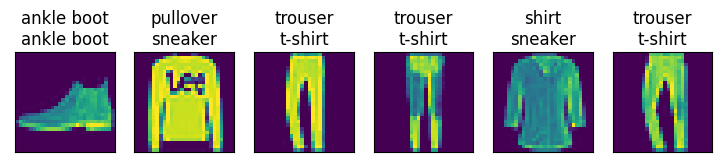

In [35]:
def predict_ch3(net, test_iter, n=6): 
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
    
predict_ch3(net, test_iter)

In [36]:
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
import time
import plotly.graph_objects as go
import cufflinks as cf
import chart_studio.plotly as py

cf.go_offline(connected = True)

## 책에서는 시각화가 너무 복잡함... 좀 더 간결하게?

In [38]:
fig = go.FigureWidget()
fig.add_scatter(name = 'loss')
fig.add_scatter(name = 'train_acc')  
fig.add_scatter(name = 'test_acc')

fig.update_layout(yaxis_range=[0,1], xaxis_range = [0,10] ,title = 'Epoch에 따른 loss 및 train/test accuracy의 변화')


FigureWidget({
    'data': [{'name': 'loss', 'type': 'scatter', 'uid': 'd2bec786-3d37-4d17-ab5b-6babc8def0e3'}…

In [40]:

train_loss_lst = []
train_acc_lst = []
test_acc_lst = []
num_epochs = 10

for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, cross_entropy, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    
    train_loss_lst.append(train_metrics[0])
    train_acc_lst.append(train_metrics[1])
    test_acc_lst.append(test_acc)
    
    with fig.batch_update():
        fig.data[0].y = train_loss_lst[:epoch]
        fig.data[1].y = train_acc_lst[:epoch]
        fig.data[2].y = test_acc_lst[:epoch]        

# 3.7

In [50]:

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [51]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

In [52]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

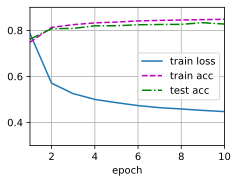

In [53]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)